<div><center><img src="https://ml.ucv.ai/logo.png\" width=150"/> </center></div>

# 04 Segmentación de imágenes con redes U-Net


Basado en:

- [Efficient Image Segmentation](https://medium.com/data-science/efficient-image-segmentation-using-pytorch-part-3-3534cf04fb89)
- [Image segmentation with a U-Net-like architecture](https://keras.io/examples/vision/oxford_pets_image_segmentation/)



# 1. Arquitecturas Encoder-Decoder (Teoría y Fórmulas)

Un modelo **encoder-decoder** transforma una entrada $ \mathbf{x} \in \mathbb{R}^n $ en una salida $ \mathbf{y} \in \mathbb{R}^m $ mediante una representación latente $ \mathbf{z} \in \mathbb{R}^d $, donde normalmente $ d < n $.

## 1.1 Encoder

El **encoder** convierte la entrada $ \mathbf{x} $ en una representación latente $ \mathbf{z} $:

$$
\mathbf{z} = f_{\text{enc}}(\mathbf{x}; \theta_e)
$$

- $ f_{\text{enc}} $: red neuronal (CNN, RNN, MLP, etc.)
- $ \theta_e $: parámetros del encoder
- $ \mathbf{z} $: vector latente comprimido

Si el encoder tiene múltiples capas:

$$
\mathbf{z} = f_L \circ f_{L-1} \circ \dots \circ f_1(\mathbf{x})
$$

En términos de dominio y codominio:

$$
f_{\text{enc}}: \mathbb{R}^n \rightarrow \mathbb{R}^d
$$

- $ \mathbf{x} \in \mathbb{R}^n $: entrada original
- $ \mathbf{z} = f_{\text{enc}}(\mathbf{x}) \in \mathbb{R}^d $: representación latente
- Típicamente $ d < n $ para compresión


## 1.2. Decoder

El **decoder** reconstruye o genera la salida a partir de $ \mathbf{z} $:

$$
\hat{\mathbf{y}} = f_{\text{dec}}(\mathbf{z}; \theta_d)
$$

- $ f_{\text{dec}} $: red decodificadora
- $ \theta_d $: parámetros del decoder
- $ \hat{\mathbf{y}} $: salida generada o reconstruida

Reconstruye o genera la salida desde el espacio latente:

$$
f_{\text{dec}}: \mathbb{R}^d \rightarrow \mathbb{R}^m
$$

- $ \mathbf{z} \in \mathbb{R}^d $: vector latente
- $ \hat{\mathbf{y}} = f_{\text{dec}}(\mathbf{z}) \in \mathbb{R}^m $: salida reconstruida o generada


## 1.3. El modelo

El modelo completo es la composición de encoder y decoder:

$$
f_{\text{dec}} \circ f_{\text{enc}}: \mathbb{R}^n \rightarrow \mathbb{R}^m
$$

Es decir:

$$
\hat{\mathbf{y}} = f_{\text{dec}}(f_{\text{enc}}(\mathbf{x}))
$$


## 1.4. Función de Pérdida

El modelo se entrena minimizando la pérdida entre la salida generada $ \hat{\mathbf{y}} $ y la salida real $ \mathbf{y} $:

$$
\mathcal{L}(\mathbf{y}, \hat{\mathbf{y}}) = \mathcal{L}\left(\mathbf{y}, f_{\text{dec}}(f_{\text{enc}}(\mathbf{x}))\right)
$$

### Ejemplos comunes:

- **Reconstrucción (autoencoder):**

$$
\mathcal{L} = \|\mathbf{x} - f_{\text{dec}}(f_{\text{enc}}(\mathbf{x}))\|^2
$$

- **Segmentación (por píxel):**

$$
\mathcal{L} = \text{CrossEntropy}(\mathbf{y}, \hat{\mathbf{y}})
$$

- **Secuencia a secuencia (traducción):**

$$
\mathcal{L} = -\sum_{t=1}^T \log P(y_t \mid \mathbf{z}, y_{<t})
$$



## 1.4. Optimización

El entrenamiento ajusta los parámetros del modelo $ \theta = \{\theta_e, \theta_d\} $ para minimizar la pérdida esperada:

$$
\theta^* = \arg \min_{\theta} \ \mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}} \left[ \mathcal{L}(\mathbf{y}, f_{\text{dec}}(f_{\text{enc}}(\mathbf{x}))) \right]
$$

Donde $ \mathcal{D} $ es el conjunto de datos de entrenamiento.



# 3. Segmentación

RAFAEL: de aqui en adelante las notas hechas por el estudiante comenzaran con "RAFAEL" para diferenciarlas de las notas en el notebook original. Las secciones de codigo sin explicacion textual en la casilla anterior vienen directamente del notebook original sin alteraciones y no consideramos necesaria su explicacion.

RAFAEL: Para esta tarea preferi usar mi maquina local la mayoria del tiempo, ya que google colab tenia un limite de unidades de computo para el free tier. Este limite se disparo varias veces, entonces configuraba el notebook para ser usado localmente (le asigne limite de memoria para el gpu).

RAFAEL: Ademas, cambie el orden de algunas funciones. La descarga de datos debia ir antes que la manipulacion de las mismas. Comente la descarga de datos para no reescribirla localmente cada vez que corria todo el notebook.

RAFAEL: Este notebook sirve en google colab sin problemas. Sin embargo al correrlo localmente se necesita un ambiente similar al que fue montado en labs.ucv.ai. En un jupyter de aws tuve varios problemas para correrlo y al final me rendi (capaz fue porque no escogi ubuntu como OS y no instale los paquetes en el orden correcto).

In [ ]:
!pip install torchinfo

RAFAEL: Aqui importamos varios paquetes necesarios. Es casi igual al notebook original con la diferencia de que tenemos la variable "IS_GPU_MEMORY_LIMITED" que usamos cuando hacemos desarrollo local con nuestra gpu de 4gb. Si tiene una GPU con mayor capacidad porfavor colocar esta variable en 0.

In [ ]:
import torch
from torch import nn
import os
from os import path
import torchvision
import torchvision.transforms as T
from typing import Sequence
from torchvision.transforms import functional as F
import numbers
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from dataclasses import dataclass
import dataclasses

#rafael: agregue esto ya que estoy usando mi maquina local
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
IS_GPU_MEMORY_LIMITED = False


if IS_GPU_MEMORY_LIMITED:
  # Get GPU devices
  gpus = tf.config.list_physical_devices('GPU')
  if gpus:
      tf.config.experimental.set_memory_growth(gpus[0], True)
      tf.config.experimental.set_virtual_device_configuration(
          gpus[0],
          [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3000)]
      )

# rafael: agregue esto porque comence a usar mi propia maquina
torch.cuda.is_available()

In [ ]:
# Convert a pytorch tensor into a PIL image
t2img = T.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = T.ToTensor()

## 3.2 Descargar los datos

RAFAEL: Estos datos tardan en descargar si las tiene localmente porfavor comentar. Esta casilla fue movida mas arriba ya que abajo hay funciones que referencian las imagenes.

In [ ]:
!!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [ ]:
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

## 3.3 Preparar los nombres de las imágenes y las máscaras

RAFAEL: a continuacion las secciones relacionadas con la data no se han modificado. Por lo tanto no hay comentarios del estudiante.

In [ ]:
import requests

def get_unsplash_image():
    image_path = "stroller-unsplash.avif"

    if not os.path.exists(image_path):
        url = "https://images.unsplash.com/photo-1687017563985-a7193fcd7032"
        r = requests.get(url, allow_redirects=True)
        with open(image_path, 'wb') as fp:
            fp.write(r.content)
        # end with
    # end if

    image_256_path = "stroller-unsplash-256.png"

    if not os.path.exists(image_256_path):
        img = Image.open(image_path)
        img = img.resize((256, 256))
        img = img.convert("RGB")
        img.save(image_256_path)
    # end if

    img = Image.open(image_256_path)
    return img

def get_pet_cat_image_and_mask():
    img = Image.open(r"images/Abyssinian_169.jpg")
    img = img.convert("RGB").resize((256, 256))

    mask = Image.open(r"annotations/trimaps/Abyssinian_169.png")
    mask = mask.convert("L").resize((256, 256))
    mask = t2img((img2t(mask) * 255. - 1.) / 2.)
    return img, mask

img, mask = get_pet_cat_image_and_mask()

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.axis("off")

plt.show()

In [ ]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Número de imágenes:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

## 3.4 Cargando las imágenes usando Keras

In [ ]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

## 3.5 Preparar dataset y batches de data

In [ ]:
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io


def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)


## 3.7 Split de validación

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=1000,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

print(train_dataset)

## Entrenamiento con Métricas específicas del dominio

Dependiendo del contexto en el que entrenemos modelos, a veces tiene sentido modificar la métrica de interés. Por ejemplo, en [Image segmentation metrics](https://keras.io/api/metrics/segmentation_metrics/) encontramos:

In [ ]:
import tensorflow as tf

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)


RAFAEL: ya que creamos varias versiones de modelos. Hemos modificado varias secciones de codigo para que sean funciones. De esta manera sera mas facil realizar distintas acciones con los modelos.

RAFAEL: la funcion de abajo simplemente es la funcion de entrenamiento.

In [ ]:
# rafael: converti esto en funcion para manejarlo mas facilmente
def fit_model(model):
  # Configure the model for training.
  # We use the "sparse" version of categorical_crossentropy
  # because our target data is integers.
  model.compile(
      optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy",
      metrics=[iou_metric, dice_coefficient]
  )

  callbacks = [
      keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True),
      keras.callbacks.TensorBoard('./logs', update_freq=1)
  ]

  # Train the model, doing validation at the end of each epoch.
  epochs = 50
  history = model.fit(
      train_dataset,
      epochs=epochs,
      validation_data=valid_dataset,
      callbacks=callbacks,
      verbose=2,
  )
  return model, history

RAFAEL: la funcion de abajo se encarga de hacer un plot con el train history. Este tiene datos de perdida durante entrenamiento y validacion. Ademas tiene metricas de validacion del DICE e IOU.

In [ ]:
def plot_training(history):
  # Plot training history
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['val_dice_coefficient'], label='Validation Dice')
  plt.plot(history.history['val_iou_metric'], label='Validation IoU')
  plt.title('Custom metrics')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

RAFAEL: aqui mostramos la prediccion de un modelo dado un indice. El indice representa una imagen en el dataset. Esta funcion muestra la imagen original, el target y la prediccion.

In [ ]:
from keras.models import load_model
from IPython.display import Image, display

def show_prediction(model, i=10):
  # Generate predictions for all images in the validation set
  val_dataset = get_dataset(
      batch_size, img_size, val_input_img_paths, val_target_img_paths
  )
  val_preds = model.predict(val_dataset)

  def display_mask(i):
      """Quick utility to display a model's prediction."""
      mask = np.argmax(val_preds[i], axis=-1)
      mask = np.expand_dims(mask, axis=-1)
      img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
      display(img)

  # Display input image
  print("HERE",Image)
  display(Image(filename=val_input_img_paths[i]))

  # Display ground-truth target mask
  img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
  display(img)

  # Display mask predicted by our model
  display_mask(i)  # Note that the model only sees inputs at 150x150.

RAFAEL: estas funciones no estaban en el notebook original. Aqui es necesario que exista un directorio llamado "models". La primera funcion guarda un modelo y su historial de entrenamiento dado un prefijo que le asigna el usuario.

La segunda funcion trae devuelta esa informacion dado el prefijo. Esta no es usada en el resto del notebook, se asume que el mismo sera corrido de 0. Igual se guardan los modelos localmente

In [ ]:
import os
import pickle
import json
import tensorflow as tf
from tensorflow import keras

def save_experiment(model, history, prefix):
    experiment_dir = f"models/{prefix}"
    os.makedirs(experiment_dir, exist_ok=True)

    model_path = os.path.join(experiment_dir, "model.keras")
    model.save(model_path)

    history_pickle_path = os.path.join(experiment_dir, "history.pkl")
    with open(history_pickle_path, 'wb') as f:
        pickle.dump(history.history, f)

    return experiment_dir


def load_experiment(prefix):
    experiment_dir = f"experiments/{prefix}"

    if not os.path.exists(experiment_dir):
        raise FileNotFoundError(f"Experiment directory not found: {experiment_dir}")

    model = None
    history = None
    history_pickle_path = os.path.join(experiment_dir, "history.pkl")
    with open(history_pickle_path, 'rb') as f:
        history = pickle.load(f)

    return model, history, experiment_dir

## Modelos

RAFAEL: a continuacion los distintos modelos y el original. Se puede comparar tanto el historial de entrenamiento como una unica prediccion.

### Original

In [ ]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Build model
model = get_model(img_size, num_classes)
model.summary()

RAFAEL: Algo que tuve bastante presente durante la creacion de este notebook es la cantidad de parametros totales en cada modelo. Debido a que la mayoria del desarrollo ser realizo con tiempo y un GPU local, evite crear modelos por encima de los 2.3M de parametros. Por encima de este numero mi GPU (aun con la configuracion para solo gastar 3Gb) no era capaz de entrenarlo.

In [ ]:
model, train_history = fit_model(model)
save_experiment(model,train_history, "original")

RAFAEL: segun observamos, el DICE (el cual consideramos una de las metricas mas importantes), no llega a 0.9. La metrica IOU supera el 0.8. Durante el entrenamiento estas metricas parecen mantenerse fuertes y luego bajan y reducen su estabilidad.

La perdida en validacion parece aumentar bastante y luego bajar y regularse. Al tratar de predecir la segmentacion del pug, evidentemente tenemos problemas. Ni siquiera se obtienen bordes suaves.

In [ ]:
plot_training(train_history)

In [ ]:
show_prediction(model,10)

### V1 - Eliminando la suma de capas anteriores

RAFAEL: Al principio me interesaba mas reducir el costo de aprendizaje para poder entrenar estas redes en mi GPU local. Al eliminar la suma residual (Resnet, suma del outuput de capas anteriores) la cantidad de parametros a entrenar disminuyo. Y los bordes de las predicciones se hicieron ligeramente mas nitidos, a diferencia del modelo anterior.

Este es el unico cambio en esta parte, el resto lo dejamos igual.

In [ ]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# Build model
modelv1 = get_model(img_size, num_classes)
modelv1.summary()

In [ ]:
model, train_history = fit_model(modelv1)
save_experiment(model,train_history, "v1")

Aun asi la precision del modelo para generar los bordes correctos no es suficiente. Las metricas de DICE e IOU aun siguen siendo muy similares al modelo original.

In [ ]:
plot_training(train_history)

In [ ]:
show_prediction(modelv1,10)

### V2 - Cambiando la estructura de la red

RAFAEL: En esta seccion hicimos bastantes cambios importantes a la red. Eliminamos el entry block para que fuera parte de la seccion de downsampling. Ademas que cambiamos las "SeparableConv2D" por convoluciones normales. Cambiamos el orden de las convoluciones, primero convolucion, batch normalization y luego la capa de activacion. Ademas ahora los conjuntos de capas/canales (loops en el codigo) van de 16 a 128 en vez de 64 a 256.

In [ ]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = inputs

    for filters in [16, 32, 64, 128]:
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    for filters in [128, 64, 32, 16]:
        x = layers.UpSampling2D(2)(x)

        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size, num_classes)
model.summary()

In [ ]:
model, train_history = fit_model(model)
save_experiment(model,train_history, "v2")

Para este modelo los bordes siguen siendo mas limpios. Sin embargo la precision de la segmentacion sigue siendo muy similar a la del modelo original. Todavia no hemos logrado las mejoras que buscamos. Aun asi fue mas facil trabajar con este modelo debido a que solo tenia 700k parametros.

In [ ]:
plot_training(train_history)

In [ ]:
show_prediction(model,10)

### V3 - Agregando convoluciones Depthwise

Siguiendo la recomendacion de los articulos mencionados al principio del notebook, aqui usamos deepwise convolutions. Estas redujeron bastante la cantidad de parametros.

Ademas se tuvieron que realizar mas cambios relacionados a los ciclos. Estas capas reciben un "depth_multiplier" que basicamente multiplica la cantidad de canales anteriores y esa es la cantidad de canales que crean. Entonces ya que comenzamos con 3 canales (RGB), estos luego se multiplican por 10 (30). Luego por 2, 3 veces (60,120,240).

No agregamos otra multiplicacion ya que era demasiado amplio el modelo para el gpu local. La segunda convolucion de cada loop tiene un depth_multiplier de 1 para evitar cambiar la cantidad de canales.

In [ ]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = inputs
    ### [First half of the network: downsampling inputs] ###

    for filter_multiplier in [10, 2, 2, 2]:
        # Rafael: depth_multiplier multiplica la cantidad de filtros/canales anteriores.
        # esto indica que pasaremos de 3 canales a 30, 60, 120 y 240
        x = layers.DepthwiseConv2D(3, depth_multiplier=filter_multiplier, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        # rafael: aqui solo aplicamos depth_multiplier con 1. Para mantener la cantidad de canales
        x = layers.DepthwiseConv2D(3, depth_multiplier=1, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    ### [Second half of the network: upsampling inputs] ###
    for filters in [240, 120, 60, 30]:
        x = layers.UpSampling2D(2)(x)

        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# Build model
model = get_model(img_size, num_classes)
model.summary()

In [ ]:
model, train_history = fit_model(model)
save_experiment(model,train_history, "v3")

El performance sigue siendo muy similar al del modelo original sin muchos cambios. Visualmente logra resultados similares y poco precisos tambien. El DICE e IOU parecen mas estables por epocas durante el entrenamiento.

In [ ]:
plot_training(train_history)

In [ ]:
show_prediction(model,10)

### V4 - Modelo original con depthwise

RAFAEL: Luego de esto recorde que el profesor requeria que usaramos este nuevo tipo de convolucion. En este caso simplemente reemplace las convoluciones de las capas de downsampling con con deepwise convolutions. Para esto, como antes, cambiamos los arreglos de los loops para que actuaran como un depth multiplier y cambiamos la cantidad de canales en el upsampling para que hicieran match con este cambio.

In [ ]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block

    x = layers.DepthwiseConv2D(3, depth_multiplier=10, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [2, 2, 2]:
        x = layers.Activation("relu")(x)
        x = layers.DepthwiseConv2D(3, depth_multiplier=filters, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.DepthwiseConv2D(3, depth_multiplier=1, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.DepthwiseConv2D(1, depth_multiplier=filters, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [240, 120, 60, 30]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Build model
model = get_model(img_size, num_classes)
model.summary()

In [ ]:
model, train_history = fit_model(model)
save_experiment(model,train_history, "v4")

Esto no mejoro el performance del modelo aunque si redujo bastante la cantidad de parametros.

Luego de esto decidimos abandonar el uso de usar convoluciones depthwise. Agarramos el modelo con mejor performance

In [ ]:
plot_training(train_history)

In [ ]:
show_prediction(model,10)

### V5 - Sin depthwise y mas capas y canales

RAFAEL: Aqui dejamos de usar depthwise. Agarramos el mejor modelo de los anteriores (el v2) y extendimos la cantidad de capas en los ciclos (en consecuencia mas convoluciones entre capas de activacion. Esto tenia un limite (que podiamos cambiar), debido a que cada ciclo hacia un maxpooling, las imagenes son $160 * 160 = 2^5 * 5$. Esto quiere decir que solo podemos realizar 5 veces maxpooling antes de no poder regresar al tamaño original.

Asimismo hicimos las modificaciones pertinentes a las capas de upsampling para hacer match con los canales de downsampling.

In [ ]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = inputs

    for filters in [32, 64, 128, 128, 128]:
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    for filters in  [128, 128, 128, 64, 32]:
        x = layers.UpSampling2D(2)(x)

        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# Build model
model = get_model(img_size, num_classes)
model.summary()

Este modelo tampoco tuvo una mejora en las metricas. Incluso no llega al 0.9 en DICE como modelos anteriores. Observando la perdida del modelo en validacion y entrenamiento pense que podriamos estar ante un caso de overfitting.

In [ ]:
model, train_history = fit_model(model)
save_experiment(model,train_history, "v5")

In [ ]:
plot_training(train_history)

In [ ]:
show_prediction(model,10)

### V6 - Con dropout

El mismo modelo de la version anterior, agregando una capa de dropout. En este caso investigamos mas la libreria de keras y encontramos [SpatialDropout2D](https://keras.io/api/layers/regularization_layers/spatial_dropout2d/).

Con esta capa de dropout, y luego de algo de [investigacion](https://stats.stackexchange.com/questions/282282/how-is-spatial-dropout-in-2d-implemented), concluimos que era mejor usarla que el mismo dropout. Esto es debido a que al desactivar valores para pixeles individuales, no necesariamente conseguimos el objetivo del dropout en si, ya que se puede obtener contexto de la imagen incluso si hay pixeles en 0. En cambio esta capa de dropout se encarga de colocarlos en 0 a lo largo de todo el canal, lo cual tiene un efecto distinto y mas efectivo cuando se trata de dropout.

In [ ]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = inputs

    dropout_rate = 0.1
    for filters in [32, 64, 128, 180]:
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.SpatialDropout2D(dropout_rate)(x)

        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    for filters in  [180, 128, 64, 32]:
        x = layers.UpSampling2D(2)(x)

        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.SpatialDropout2D(dropout_rate)(x)

        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# Build model
model = get_model(img_size, num_classes)
model.summary()

In [ ]:
model, train_history = fit_model(model)
save_experiment(model,train_history, "v6")

Como era de esperarse la distancia entre la perdida de entrenamiento y validacion se redujo. Aunque el DICE e IOU bajaron mucho mas. Las imagenes que escogimos para revisar el performance parecen mas estables todavia.

In [ ]:
plot_training(train_history)

In [ ]:
show_prediction(model,10)

### V7 - Hasta 512 canales

Usando v2. que es el que mejor performance tuvo en las metricas

Para esto hicimos una regresion en versiones.. Volvimos al modelo V2 ya que este tuvo las mejores metricas. Incrementamos los canales hasta llegar a 512 (en este momento teniamos acceso a las computadoras de la escuela). Dejamos las capas de dropout y no hicimos mas cambios.

Esto nos da un modelo mucho mas grande, con 8,845,379 parametros. Este fue nuestro ultimo intento de un nuevo modelo que incrementara el performance.

Adjuntamos los resultados del entrenamiento y prediccion al final, ya que parece que el jupyter notebook no esta guardando el output en github.

In [ ]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = inputs
    ### [First half of the network: downsampling inputs] ###

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [32, 64, 128, 512]:
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.SpatialDropout2D(0.1)(x)

        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    ### [Second half of the network: upsampling inputs] ###
    for filters in [512, 128, 64, 32]:
        x = layers.UpSampling2D(2)(x)

        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.SpatialDropout2D(0.1)(x)

        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# Build model
model = get_model(img_size, num_classes)
model.summary()

In [ ]:
model, train_history = fit_model(model)
save_experiment(model,train_history, "v7")

In [ ]:
plot_training(train_history)

In [ ]:
show_prediction(model,10)

Mejores resultados luego de entrenar y probar el modelo:

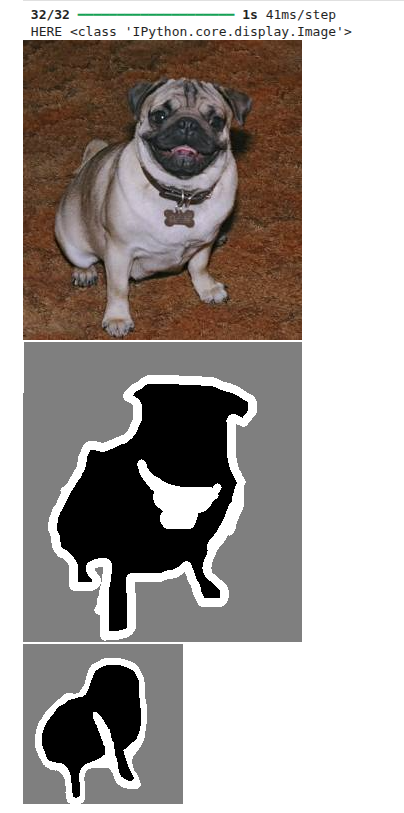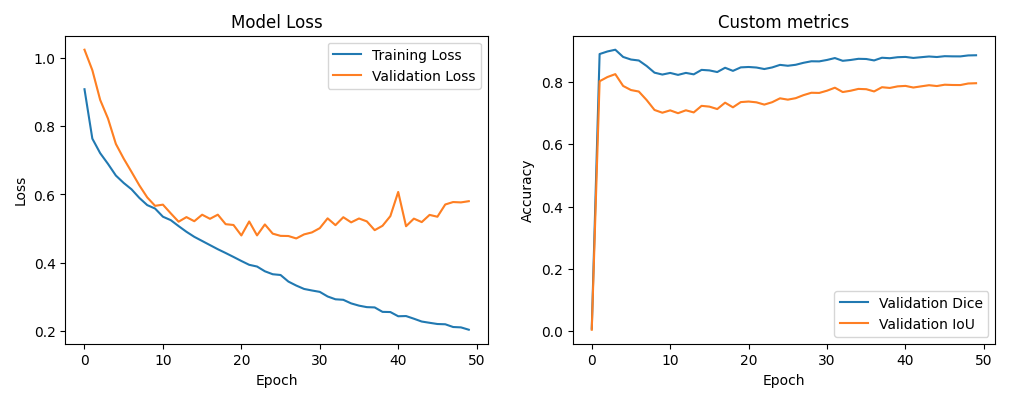